# Connect and Import

In [ ]:
# Connect google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pickle
import time
import torch
import torch.nn as nn
import multiprocessing
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# Dataset

Download dataset

In [ ]:
!cp /content/drive/MyDrive/deepfake_ds/ds_split_pkl.zip /content/
!unzip /content/ds_split_pkl.zip -d /content/ds_split

In [ ]:
class VideoROIDataset(Dataset):
    def __init__(self, txt_file, pickle_dir, buffer_size=44):                   # 44, 13, 7 batches
        self.pickle_dir = pickle_dir
        self.buffer_size = buffer_size
        self.lock = multiprocessing.Lock()  # Lock per sincronizzazione

        with open(txt_file, "r") as f:
            self.video_list = [line.strip().split(",")[0] for line in f]

        self.pickle_files = sorted(
            [os.path.join(self.pickle_dir, f) for f in os.listdir(self.pickle_dir) if f.endswith(".pkl")],
            key=lambda x: int(x.split("_")[-1].split(".")[0])  # Ordina numericamente
        )
        self.total_videos = len(self.video_list)
        self.data = []
        self.current_file_idx = 0
        self._load_next_buffer()

    def _load_next_buffer(self):
        with self.lock:
            # Check buffer
            if self.data:
                return

            if self.current_file_idx >= len(self.pickle_files):
                return

            self.data = []
            files_loaded = 0
            while files_loaded < self.buffer_size and self.current_file_idx < len(self.pickle_files):
                file_path = self.pickle_files[self.current_file_idx]
                print(f"Loading file: {file_path}")
                with open(file_path, "rb") as f:
                    self.data.extend(pickle.load(f))
                self.current_file_idx += 1
                files_loaded += 1

            if not self.data:
                raise IndexError("No pickle available!")

    def __getitem__(self, index):
        if not self.data or index >= len(self.data):
            self._load_next_buffer()
            if not self.data:
                raise IndexError("Buffer is empty after loading")

        video_data = self.data[index % len(self.data)]
        eyes = torch.stack(video_data["eyes"])
        nose = torch.stack(video_data["nose"])
        mouth = torch.stack(video_data["mouth"])
        label = torch.tensor(video_data["label"], dtype=torch.float32)

        return {"eyes": eyes, "nose": nose, "mouth": mouth, "label": label}

    def __len__(self):
        return self.total_videos

# Percorsi dei file e directory
train_txt = "/content/ds_split/train_ds.txt"
test_txt = "/content/ds_split/test_ds.txt"
val_txt = "/content/ds_split/val_ds.txt"

# Directory dei batch
train_batches_dir = "/content/ds_split/train_batches"
test_batches_dir = "/content/ds_split/test_batches"
val_batches_dir = "/content/ds_split/val_batches"

# Creazione dei Dataset
train_dataset = VideoROIDataset(train_txt, train_batches_dir)
test_dataset = VideoROIDataset(test_txt, test_batches_dir)
val_dataset = VideoROIDataset(val_txt, val_batches_dir)

# Creazione dei DataLoader
dl_batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=dl_batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=dl_batch_size, shuffle=False, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=dl_batch_size, shuffle=False, num_workers=2)

print("DataLoader created succesfully!")

# Model

## Model Definition

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultiInputMobileNetLSTM(nn.Module):
    def __init__(self, num_frames=20, num_classes=2, class_weights=None):
        super(MultiInputMobileNetLSTM, self).__init__()
        self.num_frames = num_frames

        # Backbone MobileNetV2 for each ROI
        self.backbone_eyes = self._initialize_mobilenet()
        self.backbone_nose = self._initialize_mobilenet()
        self.backbone_mouth = self._initialize_mobilenet()

        # GAP Layer
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        # LSTM for time analysis
        feature_dim = 1280;
        self.lstm = nn.LSTM(input_size=feature_dim * 3, hidden_size=512, num_layers=1, batch_first=True)

        # Fully connected layer for classification
        self.fc = nn.Linear(512, 1)

        # Add class weights if given
        if class_weights is not None:
            self.class_weights = torch.tensor(class_weights, dtype=torch.float32)
        else:
            self.class_weights = None

    # Initialize MobileNetV2 with first frozen layers
    def _initialize_mobilenet(self):
        mobilenet = models.mobilenet_v2(pretrained=True, width_mult=1)

        # Freeze first 14 layers
        for idx, layer in enumerate(mobilenet.features):
            if idx < 14:
                for param in layer.parameters():
                    param.requires_grad = False

        return nn.Sequential(*mobilenet.features)


    def forward(self, eyes, nose, mouth):
        batch_size = eyes.size(0) // self.num_frames

        # Extract feature through backbone MobileNet
        eyes_features = self.backbone_eyes(eyes)  # [B*num_frames, 1280, 1, 1]
        nose_features = self.backbone_nose(nose)
        mouth_features = self.backbone_mouth(mouth)

        # Apply Global Average Pooling
        eyes_features = self.gap(eyes_features).squeeze(-1).squeeze(-1)  # [B*num_frames, 1280]
        nose_features = self.gap(nose_features).squeeze(-1).squeeze(-1)
        mouth_features = self.gap(mouth_features).squeeze(-1).squeeze(-1)

        # Resize to proper dimensions
        eyes_features_2 = eyes_features.view(batch_size, self.num_frames, -1)  # [B, num_frames, 1280]
        nose_features_2 = nose_features.view(batch_size, self.num_frames, -1)
        mouth_features_2 = mouth_features.view(batch_size, self.num_frames, -1)

        # Concatenation
        concatenated_features = torch.cat((eyes_features_2, nose_features_2, mouth_features_2), dim=2)  # [B, num_frames, 3840]

        # LSTM for time analysis
        lstm_out, _ = self.lstm(concatenated_features)  # [B, num_frames, 512]

        # Use onl last frame output for classification
        lstm_final_output = lstm_out[:, -1, :]  # [B, 512]

        # Fully connected layer
        logits = self.fc(lstm_final_output)  # [B, 1]

        # Aplly sigmoid for probabilities
        probabilities = torch.sigmoid(logits)  # [B, 1]

        return probabilities.squeeze()  # [B]

    def get_loss(self, outputs, labels):
        if self.class_weights is not None:
            pos_weight = torch.tensor([self.class_weights[1] / self.class_weights[0]]).to(outputs.device)
            criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        else:
            criterion = nn.BCEWithLogitsLoss()
        return criterion(outputs.squeeze(), labels.float())




# Train

In [ ]:
# Weighta for unbalanced classes compensation
total_real = 826
total_fake = 5414
class_weights = [1.0 / total_real, 1.0 / total_fake]

### forward test

Function to test forward pass, mainly for debug

In [ ]:
# Initialize the model
model = MultiInputMobileNetLSTM(class_weights=class_weights)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Script for forward method test
def test_forward():
    # Parameters
    batch_size = 8  # Numero di video nel batch
    num_frames = 20  # Numero di frame per video
    input_size = (3, 64, 64)  # Dimensioni di ciascun frame (C, H, W)

    # Test with random data
    eyes = torch.randn(batch_size * num_frames, *input_size)  # [B*num_frames, 3, 64, 64]
    nose = torch.randn(batch_size * num_frames, *input_size)
    mouth = torch.randn(batch_size * num_frames, *input_size)

    model.eval()

    # Execute forward pass
    with torch.no_grad():
        outputs = model(eyes, nose, mouth)

    # Print results
    print(f"Output shape: {outputs.shape}")  # [B]
    print(f"Outputs: {outputs}")

# Run the test
test_forward()

### checkpoint download

To start training from a specified checkpoint. DON'T RUN

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/deepfake_ds/model_checkpoints/"
model.load_state_dict(torch.load(f"{CHECKPOINT_PATH}best_model.pth"))
model = model.to(device)

## Train loop

In [ ]:
# Path for checkpoints
CHECKPOINT_PATH = "/content/drive/MyDrive/deepfake_ds/model_checkpoints/"

# Early Stopping
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = float("inf")
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Model initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiInputMobileNetLSTM(class_weights=class_weights)
model = model.to(device)

# Loss and optimizer
pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=0.001)

# Training configuration
num_epochs = 30
early_stopping = EarlyStopping(patience=5)  # Early stopping dopo 5 epoche senza miglioramenti

# Training loop
best_val_loss = float("inf")
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        eyes = batch["eyes"].view(-1, 3, 64, 64).to(device)
        nose = batch["nose"].view(-1, 3, 64, 64).to(device)
        mouth = batch["mouth"].view(-1, 3, 64, 64).to(device)
        labels = batch["label"].float().to(device)

        # Forward pass
        outputs = model(eyes, nose, mouth)  # [B, 1] -> [B]
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}")

    # Validation step
    model.eval()
    total_correct = 0
    total_samples = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            eyes = val_batch["eyes"].view(-1, 3, 64, 64).to(device)
            nose = val_batch["nose"].view(-1, 3, 64, 64).to(device)
            mouth = val_batch["mouth"].view(-1, 3, 64, 64).to(device)
            labels = val_batch["label"].float().to(device)

            outputs = model(eyes, nose, mouth)  # [B, 1] -> [B]
            val_loss += criterion(outputs, labels).item()

            predicted = (outputs > 0.5).long()  # Soglia per BCE
            total_correct += (predicted == labels.long()).sum().item()
            total_samples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Save checkpoint we have if better validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"{CHECKPOINT_PATH}best_model_2.pth")
        print(f"Saved checkpoint: improved Validation Loss {best_val_loss:.4f}")

    # Early Stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Activated early stopping!")
        break

    epoch_time = time.time() - start_time
    print(f"Time for epoch: {epoch_time / 60:.2f} minutes")


Epoch [1/30] Training Loss: 0.1610
Epoch [1/30] Validation Loss: 0.1534, Accuracy: 0.8131
Checkpoint salvato: Validation Loss migliorata a 0.1534
Tempo per epoca: 12.03 minuti
Epoch [2/30] Training Loss: 0.1519
Epoch [2/30] Validation Loss: 0.1502, Accuracy: 0.8387
Checkpoint salvato: Validation Loss migliorata a 0.1502
Tempo per epoca: 12.29 minuti
Epoch [3/30] Training Loss: 0.1500
Epoch [3/30] Validation Loss: 0.1522, Accuracy: 0.8562
Tempo per epoca: 12.22 minuti
Epoch [4/30] Training Loss: 0.1479
Epoch [4/30] Validation Loss: 0.1520, Accuracy: 0.8978
Tempo per epoca: 12.43 minuti
Epoch [5/30] Training Loss: 0.1468
Epoch [5/30] Validation Loss: 0.1484, Accuracy: 0.9185
Checkpoint salvato: Validation Loss migliorata a 0.1484
Tempo per epoca: 12.20 minuti
Epoch [6/30] Training Loss: 0.1446
Epoch [6/30] Validation Loss: 0.1499, Accuracy: 0.8930
Tempo per epoca: 12.14 minuti
Epoch [7/30] Training Loss: 0.1439
Epoch [7/30] Validation Loss: 0.1460, Accuracy: 0.9249
Checkpoint salvato: Va

### Saved metrics version

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

# Ciclo di addestramento
best_val_loss = float("inf")
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        eyes = batch["eyes"].view(-1, 3, 64, 64).to(device)
        nose = batch["nose"].view(-1, 3, 64, 64).to(device)
        mouth = batch["mouth"].view(-1, 3, 64, 64).to(device)
        labels = batch["label"].float().to(device)

        # Forward pass
        outputs = model(eyes, nose, mouth)  # [B, 1] -> [B]
        loss = criterion(outputs, labels)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Training Loss: {avg_train_loss:.4f}")

    # Validazione
    model.eval()
    total_correct = 0
    total_samples = 0
    val_loss = 0.0
    with torch.no_grad():
        for val_batch in val_loader:
            eyes = val_batch["eyes"].view(-1, 3, 64, 64).to(device)
            nose = val_batch["nose"].view(-1, 3, 64, 64).to(device)
            mouth = val_batch["mouth"].view(-1, 3, 64, 64).to(device)
            labels = val_batch["label"].float().to(device)

            outputs = model(eyes, nose, mouth)  # [B, 1] -> [B]
            val_loss += criterion(outputs, labels).item()

            predicted = (outputs > 0.5).long()  # Soglia per BCE
            total_correct += (predicted == labels.long()).sum().item()
            total_samples += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = total_correct / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_accuracy:.4f}")

    # Salva le metriche
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Salvataggio del checkpoint se migliora
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"{CHECKPOINT_PATH}best_model_2.pth")
        print(f"Saved checkpoint: improved Validation Loss {best_val_loss:.4f}")

    # Early Stopping
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print("Activated early stopping!")
        break

    epoch_time = time.time() - start_time
    print(f"Time for epoch: {epoch_time / 60:.2f} minutes")

## Test step

In [ ]:
CHECKPOINT_PATH = "/content/drive/MyDrive/deepfake_ds/model_checkpoints/"

# Load weights
model.load_state_dict(torch.load(f"{CHECKPOINT_PATH}best_model.pth", weights_only=True))
model.eval()
test_loss = 0.0
total_correct = 0
total_samples = 0

with torch.no_grad():
    for test_batch in test_loader:
        eyes = test_batch["eyes"].view(-1, 3, 64, 64).to(device)   # Da [batch_size, 20, 3, 64, 64] a [batch_size*20, 3, 64, 64]
        nose = test_batch["nose"].view(-1, 3, 64, 64).to(device)
        mouth = test_batch["mouth"].view(-1, 3, 64, 64).to(device)
        labels = test_batch["label"].to(device)

        outputs = model(eyes, nose, mouth)
        test_loss += criterion(outputs, labels).item()

        predicted = (outputs > 0.5).long()
        total_correct += (predicted == labels.long()).sum().item()
        total_samples += labels.size(0)

avg_test_loss = test_loss / len(test_loader)
test_accuracy = total_correct / total_samples
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.1791, Test Accuracy: 0.8869


## Graph

In [ ]:
# Results from previous iteration (14 epochs, early stopping)
train_losses = [0.1610, 0.1519, 0.1500, 0.1479, 0.1468, 0.1446, 0.1439, 0.1435, 0.1424, 0.1430, 0.1424, 0.1408, 0.1424, 0.1413]
val_losses = [0.1534, 0.1502, 0.1522, 0.1520, 0.1484, 0.1499, 0.1460, 0.1469, 0.1431, 0.1447, 0.1453, 0.1465, 0.1477, 0.1455]
val_accuracies = [0.8131, 0.8387, 0.8562, 0.8978, 0.9185, 0.8930, 0.9249, 0.9026, 0.8770, 0.8722, 0.9201, 0.9361, 0.8994, 0.9201]

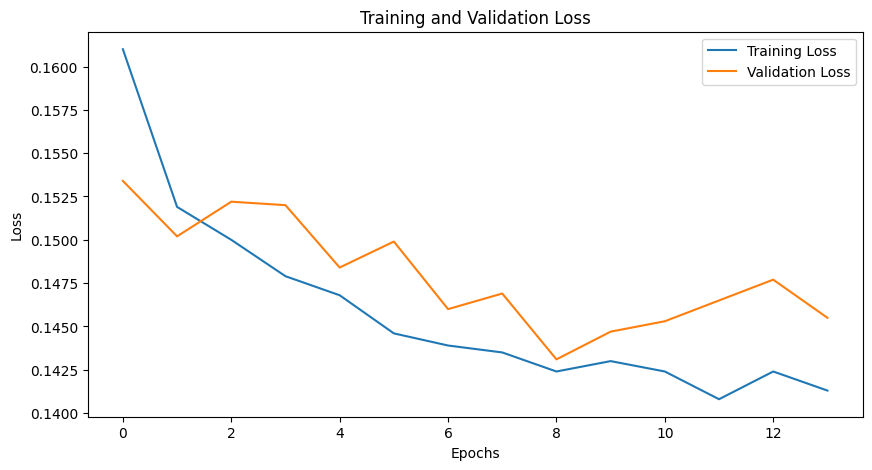

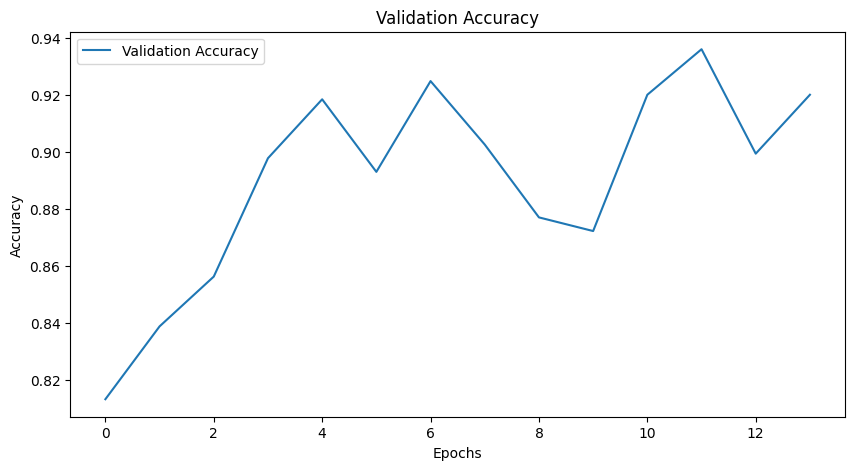

In [ ]:
import matplotlib.pyplot as plt

# Loss Graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Accuracy Graph
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()
